In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation,
    ZeroPadding2D,
    LeakyReLU,
    UpSampling2D,
    Conv2D,
    Convolution2D,
    MaxPooling2D,
    Concatenate,
    GaussianNoise,
    GaussianDropout,
    Lambda,
    GlobalAveragePooling2D,
)

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

import h5py
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import pathlib

import time

import math

In [2]:
print("Tensorflow version: ", tf.version.VERSION)  # tf2
print("Keras version: ", tf.keras.__version__)  # 2.2.4-tf

# tf.enable_eager_execution()  # tf2
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.config.list_physical_devices("GPU"))  # tf2

Tensorflow version:  2.1.0
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path_all_tfrecord = "fp56.tfrecord"

path_train_tfrecord = "fp56_train.tfrecord"
path_test_tfrecord = "fp56_test.tfrecord"

# model save dir

In [4]:
dir_model = "vgg_cam/"
pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [5]:
fp_dim = (56, 56, 6)


def _parse_function(example_proto):
    # Create a description of the features.
    feature_description = {
        "floorplan": tf.io.FixedLenFeature(
            fp_dim, tf.float32, default_value=tf.zeros(fp_dim, tf.float32)
        ),
        "plan_id": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "year": tf.io.FixedLenFeature([], tf.int64, default_value=-1),  # 0~9
        # "sido": tf.FixedLenFeature([], tf.int64, default_value=-1),
        # "norm_area": tf.FixedLenFeature([], tf.float32, default_value=0.0),
        # "num_rooms": tf.FixedLenFeature([], tf.int64, default_value=-1),
        # "num_baths": tf.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    return parsed_example["floorplan"], parsed_example["year"]

In [6]:
def create_dataset(filepath):
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=4)

    ### preprocess the features

    # won't use it. use sparse_categorical_crossentropy instead of categorical_crossentropy.
    #     dataset = dataset.map(_onehot_year, num_parallel_calls=4)

    return dataset

In [7]:
def VGG16_convolutions():
    if K.image_data_format() == "channels_last":
        input_shape = (fp_dim[0], fp_dim[1], fp_dim[2])
    else:
        input_shape = (fp_dim[2], fp_dim[0], fp_dim[1])

    model = Sequential()
    model.add(
        Conv2D(
            64,
            (3, 3),
            activation="relu",
            name="conv1_1",
            padding="same",
            input_shape=input_shape,
        )
    )
    model.add(Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(1, 1), padding="same"))

    model.add(Conv2D(128, (3, 3), activation="relu", name="conv2_1", padding="same"))
    model.add(Conv2D(128, (3, 3), activation="relu", name="conv2_2", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(1, 1), padding="same"))

    model.add(Conv2D(256, (3, 3), activation="relu", name="conv3_1", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", name="conv3_2", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", name="conv3_3", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation="relu", name="conv4_1", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv4_2", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv4_3", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation="relu", name="conv5_1", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv5_2", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv5_3", padding="same"))
    return model

In [8]:
num_classes = 10


def create_model():
    model = VGG16_convolutions()

    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

# run

In [9]:
# .repeat().shuffle(4096).batch(8)

train_dataset = create_dataset(path_train_tfrecord).shuffle(1024).batch(8)
test_dataset = create_dataset(path_test_tfrecord).batch(8)

train_dataset, test_dataset

(<BatchDataset shapes: ((None, 56, 56, 6), (None,)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((None, 56, 56, 6), (None,)), types: (tf.float32, tf.int64)>)

In [10]:
model = create_model()

In [11]:
# model-12-1.23.hdf5 - loss: 1.2337 - accuracy: 0.5033 - train accuracy: 0.5749
# model-14-1.27.hdf5 - loss: 1.2704 - accuracy: 0.5168 - train accuracy: 0.6033
# model-16-1.35.hdf5 - loss: 1.3514 - accuracy: 0.5331 - train accuracy: 0.6455 #########

path_best = dir_model + "model-16-1.35.hdf5"
path_best

'vgg_cam/model-16-1.35.hdf5'

In [12]:
model.load_weights(path_best)

In [13]:
# loss, acc = model.evaluate(test_dataset, verbose=1)

# predict

In [14]:
def _parse_single(example_proto, feature_id):
    # Create a description of the features.
    feature_description = {
        "floorplan": tf.io.FixedLenFeature(
            fp_dim, tf.float32, default_value=tf.zeros(fp_dim, tf.float32)
        ),
        "plan_id": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "year": tf.io.FixedLenFeature([], tf.int64, default_value=-1),  # 0~9
        "sido": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
        "num_rooms": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    return parsed_example[feature_id]

In [15]:
def create_single_dataset(filepath, feature_id):
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(lambda x: _parse_single(x, feature_id), num_parallel_calls=4)

    return dataset

In [16]:
all_dataset = create_dataset(path_all_tfrecord).batch(64)

In [17]:
predictions = model.predict(all_dataset, verbose=1)

    788/Unknown - 284s 361ms/step

In [18]:
predictions = np.argmax(predictions, 1)

In [19]:
predictions[:128]

array([6, 6, 7, 6, 3, 2, 4, 5, 4, 6, 3, 9, 3, 2, 4, 4, 4, 4, 3, 4, 5, 4,
       4, 5, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 3,
       3, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 7, 4, 3, 4, 4, 3, 4, 7, 7,
       7, 6, 9, 6, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 7, 7, 7, 4, 7, 8, 8, 8,
       7, 7, 8, 7, 8, 4, 6, 6, 4, 8, 6, 4, 7, 7, 4, 7, 3, 4, 4, 4, 4, 4,
       8, 7, 7, 7, 7, 7, 7, 6, 6, 6, 8, 4, 4, 5, 8, 8, 7, 8])

In [20]:
all_year = create_single_dataset(path_all_tfrecord, "year")
year_true = np.fromiter((y.numpy() for y in all_year), int)
year_true.shape, year_true[:10]

((50412,), array([6, 6, 6, 6, 2, 2, 2, 2, 2, 2]))

In [21]:
all_id = create_single_dataset(path_all_tfrecord, "plan_id")
ids = [i.numpy().decode() for i in all_id]
ids[:10]

['8928_160',
 '8928_183',
 '8928_201A',
 '8928_204B',
 '960_35',
 '960_41',
 '960_45',
 '960_49F',
 '960_50S',
 '960_53']

In [22]:
df = pd.DataFrame(
    zip(ids, year_true, predictions), columns=["ID", "true", "prediction"],
)
df

,ID,true,prediction
0,8928_160,6,6
1,8928_183,6,6
2,8928_201A,6,7
3,8928_204B,6,6
4,960_35,2,3
...,...,...,...
50407,115454_21D,9,8
50408,115454_34E,9,9
50409,115454_36B,9,9
50410,115454_37A,9,9


In [23]:
df.to_csv("vgg_5y_prediction.csv")

In [24]:
crosstab = pd.crosstab(df.true, df.prediction)
crosstab[0] = 0
crosstab = crosstab.sort_index(0).sort_index(1)
crosstab

prediction,0,1,2,3,4,5,6,7,8,9
true,,,,,,,,,,
0,0,0,0,8,23,6,6,15,5,0
1,0,2,0,35,116,27,21,30,5,1
2,0,0,9,115,449,42,31,24,13,8
3,0,0,1,791,1081,103,90,45,45,18
4,0,0,1,433,3273,505,215,96,58,15
5,0,0,0,408,2640,2254,796,235,104,39
6,0,0,0,146,1343,1060,3709,1881,621,94
7,0,0,0,30,284,159,1434,8419,1966,99
8,0,0,0,8,56,7,173,1946,6824,1007


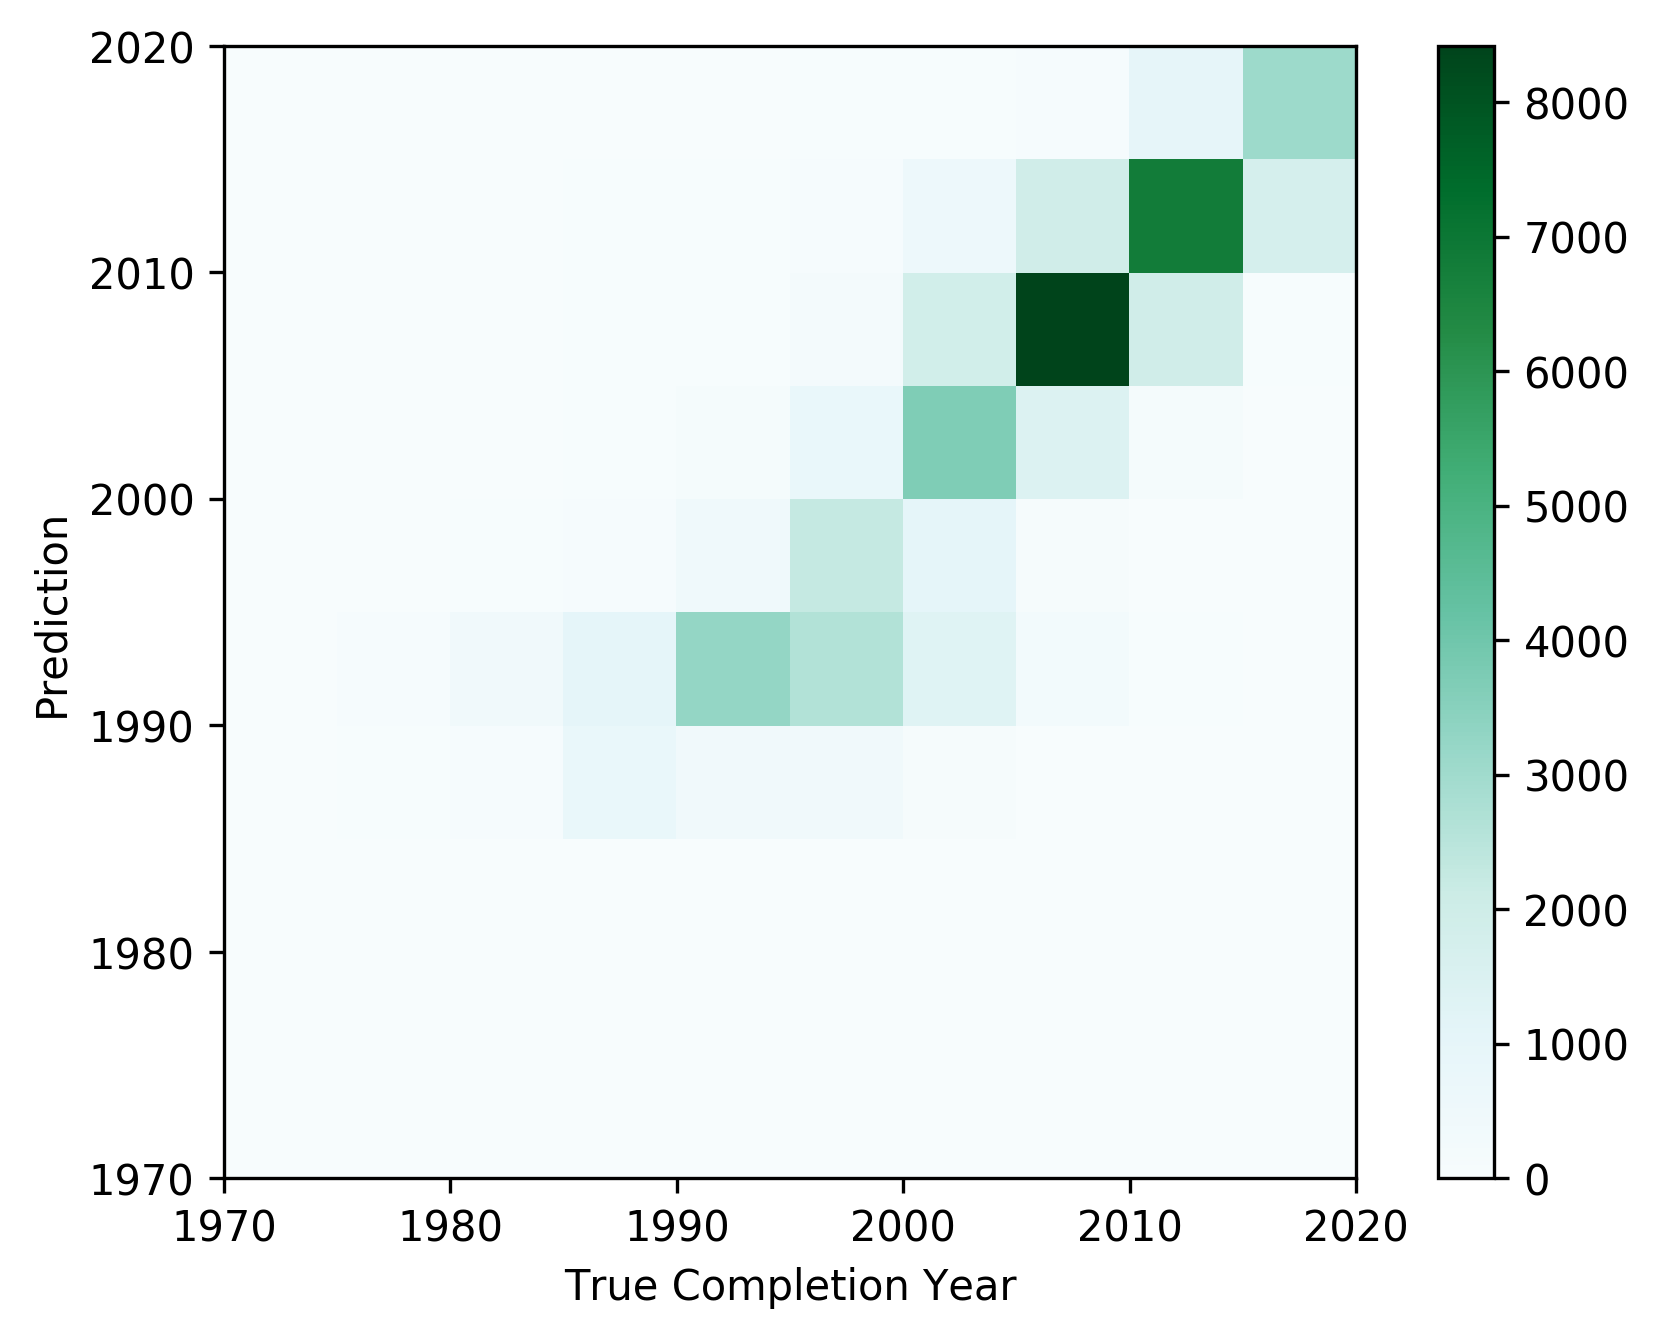

In [25]:
fig = plt.figure(figsize=(7, 5), dpi=300)
ax = fig.gca()
c = ax.pcolor(crosstab.transpose(), cmap="BuGn")
ax.set_aspect("equal")
ax.set_xlabel("True Completion Year")
ax.set_ylabel("Prediction")


def year_from_class(year_class):
    return int(1970 + 5 * year_class)


ax.set_xticklabels([str(year_from_class(yc)) for yc in ax.get_xticks()])
ax.set_yticklabels([str(year_from_class(yc)) for yc in ax.get_yticks()])

fig.colorbar(c, ax=ax)

fig.savefig(
    "vgg_5y_heatmap.pdf", bbox_inches="tight", pad_inches=0,
)
fig.savefig(
    "vgg_5y_heatmap.png", bbox_inches="tight", pad_inches=0,
)

### 눈 먼 정확도는 딱 한 구간 틀린 게 많다는 걸 보여주지 못함...

In [26]:
# df["correct"] = df.true == df.prediction
# df_correct = df.groupby(["true", "correct"]).count()["ID"].unstack(fill_value=0)
# df_correct = df_correct.sort_index(1, ascending=False)
# df_correct

In [27]:
correct = df[df.true == df.prediction].shape[0]
total = df.shape[0]
correct, total, f"{correct/total:.2%}"

(28362, 50412, '56.26%')

In [28]:
one_off = df[df.true -1  == df.prediction].shape[0] +df[df.true +1  == df.prediction].shape[0]
one_off, f"{one_off/total:.2%}", f"{(correct+one_off)/total:.2%}"

(16579, '32.89%', '89.15%')